In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


%matplotlib inline


In [16]:
class NeuralNetwork():
    def __init__(self,X,Y,nn_layers,n_iters=2000,alpha = 0.01,lambda_=10):
        self.X = X
        self.Y = Y
        self.nn_layers= nn_layers
        self.n_iters= n_iters
        self.alpha= alpha
        self.lambda_= lambda_
        self.params = self.random_weights_initialization(nn_layers)
        
    def tanh(self,z):
        return np.tanh(z)
    def sigmoid(self,z):
        return 1 / (1+np.exp(-z))
    def sigmoid_deriv(self,z):# z --> sigmoid(Z)
        return z * (1-z)
    def tanh_deriv(self,z): # z --> tanh(Z)
        return 1 - (z)**2
    def relu(self,Z):
        z_copy = np.array(Z,copy=True)
        return np.maximum(0,z_copy)
    def relu_backward(self,dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    
    def random_weights_initialization(self,n_layers):
        params = {}

        # n_layers --> (len-1) is no of layers and elements of list are no of neurons in (index+1)th layer

        for i in range(1,len(n_layers)):
            params["W"+str(i)] = np.random.randn(n_layers[i-1],n_layers[i]) 
            params["b"+str(i)] = b3 = np.zeros((1,n_layers[i]))

        return params
    
    
    
    def forward_prop(self,input_X,parameters):   
        cache = {
            "A0":input_X
        }
        last_index = int(len(parameters)/2)
        for i in range(1,last_index):
            cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],parameters["W"+str(i)]) + parameters["b"+str(i)]
            cache["A"+str(i)] = self.relu(cache["Z"+str(i)])

        cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                            parameters["W"+str(last_index)])  + parameters["b"+str(last_index)]
        cache["A"+str(last_index)] = self.sigmoid(cache["Z"+str(last_index)])

        return cache["A"+str(last_index)],cache
    
    
    def compute_cost(self,pred_output,actual_output,parameters,lamdba):    
        A = pred_output
        y =actual_output
        m = y.shape[0]
        norm=0
        for i in range(1,int(len(parameters)/2)):
            norm = np.linalg.norm(parameters["W"+str(i)])

        cost_ =  (1./m)* np.sum((A-y)**2) + (lamdba * norm)/(2*m)
        return np.squeeze(cost_)


    def get_accuracy_value(self,Y_hat, Y):
        testing = Y_hat.copy()
        testing[Y_hat>0.5]= 1 
        testing[Y_hat <= 0.5]=0
        return (testing == Y).all(axis=1).mean()
    
    def backward_prop(self,Y,cache,parameters):

        last_index = int(len(parameters)/2)
        m = Y.shape[0]
        back_cache = {}

        delta3  = 2*(cache["A"+str(last_index)] - Y) * self.sigmoid_deriv(cache["A"+str(last_index)])
        back_cache["dW"+str(last_index)] = np.dot(cache["A"+str(last_index-1)].T,delta3)/ m 
        back_cache["db"+str(last_index)] =np.sum(delta3,axis=0,keepdims=True)/ m 

        delta = delta3
        for i in reversed(range(1,last_index)):
            delta =self.relu_backward(np.dot(delta,parameters["W"+str(i+1)].T),cache["Z"+str(i)])
            back_cache["dW"+str(i)] = np.dot(cache["A"+str(i-1)].T,delta) / m
            back_cache["db"+str(i)] = np.sum(delta,axis=0,keepdims=True)/ m

        for i in range(1,(last_index)):
            assert (parameters["W"+str(i)].shape == back_cache["dW"+str(i)].shape) 

        return back_cache
    
    def update_params(self,params,backward_cache,learning_rate,lamdba,m):
        ferb = (learning_rate * lamdba)/m
        last_index = int(len(params)/2)
        for i in range(1,last_index+1):
            params["W"+str(i)] = (1-ferb)*params["W"+str(i)]- (learning_rate * backward_cache["dW"+str(i)])
            params["b"+str(i)] = params["b"+str(i)]- (learning_rate * backward_cache["db"+str(i)])
        return params
    
    def train(self):    
        params  = self.random_weights_initialization(self.nn_layers)
        J_cost =[]
        for i in range(self.n_iters):

            A3,cache = self.forward_prop(self.X,params)
            J = self.compute_cost(A3,self.Y,params,self.lambda_)
            J_cost.append(J)
            if (i%50 == 0):
                print("iter:",str(i),"cost:",str(J),"Accuracy:",str(self.get_accuracy_value(A3,self.Y)))
                print("----------------------------------------------------------------------")

            back_cache = self.backward_prop(self.Y,cache,params)

            self.params  = self.update_params(params,back_cache,self.alpha,self.lambda_,self.X.shape[0])
        return self.params,J_cost
    
    def predict(self,testX,threshold):    
        cache = {
            "A0":testX
        }
        last_index = int(len(self.params)/2)
        for i in range(1,last_index):
            cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],self.params["W"+str(i)]) + self.params["b"+str(i)]
            cache["A"+str(i)] = self.relu(cache["Z"+str(i)])

        cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                            self.params["W"+str(last_index)])  + self.params["b"+str(last_index)]
        cache["A"+str(last_index)] = self.sigmoid(cache["Z"+str(last_index)])

        output = np.array(cache["A"+str(last_index)],copy=True)
        output[output > threshold] = 1
        output[output <= threshold] = 0    

        return output
    
    def evaluate(self,input_X,output_y,threshold=0.5):
        predictions = self.predict(input_X, self.params,threshold)
        print( " precision:" , str(precision_score(output_y,predictions))[:5],"\n",
        "recall:",str(recall_score(output_y,predictions))[:5],"\n",
        "fl score:",str(f1_score(output_y,predictions))[:5],"\n",
        "accuracy:",str((predictions == output_y).all(axis=1).mean())[:5])
        results = confusion_matrix(output_y,predictions)
        fig, ax = plt.subplots()
        ax.matshow(results)
        for (i, j), z in np.ndenumerate(results):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        plt.show()
    
    

In [2]:
def tanh(z):
    return np.tanh(z)

def sigmoid(z):
    return 1 / (1+np.exp(-z))

def sigmoid_deriv(z):# z --> sigmoid(Z)
    return z * (1-z)

def tanh_deriv(z): # z --> tanh(Z)
    return 1 - (z)**2



def relu(Z):
    z_copy = np.array(Z,copy=True)
    return np.maximum(0,z_copy)


def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;



In [12]:
# def random_weights_initialization(n_layers):
#     params = {}
    
#     # n_layers --> (len-1) is no of layers and elements of list are no of neurons in (index+1)th layer
    
#     for i in range(1,len(n_layers)):
#         params["W"+str(i)] = np.random.randn(n_layers[i-1],n_layers[i]) 
#         params["b"+str(i)] = b3 = np.zeros((1,n_layers[i]))
        
#     return params

In [4]:
def forward_prop(input_X,parameters):   
    cache = {
        "A0":input_X
    }
    last_index = int(len(parameters)/2)
    for i in range(1,last_index):
        cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],parameters["W"+str(i)]) + parameters["b"+str(i)]
        cache["A"+str(i)] = relu(cache["Z"+str(i)])
        
    cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                        parameters["W"+str(last_index)])  + parameters["b"+str(last_index)]
    cache["A"+str(last_index)] = sigmoid(cache["Z"+str(last_index)])

    return cache["A"+str(last_index)],cache

In [5]:
def compute_cost(pred_output,actual_output,parameters,lamdba):    
    A = pred_output
    y =actual_output
    m = y.shape[0]
    norm=0
    for i in range(1,int(len(parameters)/2)):
        norm = np.linalg.norm(parameters["W"+str(i)])
        
    cost_ =  (1./m)* np.sum((A-y)**2) + (lamdba * norm)/(2*m)
    return np.squeeze(cost_)


def get_accuracy_value(Y_hat, Y):
    testing = Y_hat.copy()
    testing[Y_hat>0.5]= 1 
    testing[Y_hat <= 0.5]=0
    return (testing == Y).all(axis=1).mean()

In [6]:
def backward_prop(Y,cache,parameters):

    last_index = int(len(parameters)/2)
    m = Y.shape[0]
    back_cache = {}
    
    delta3  = 2*(cache["A"+str(last_index)] - Y) * sigmoid_deriv(cache["A"+str(last_index)])
    back_cache["dW"+str(last_index)] = np.dot(cache["A"+str(last_index-1)].T,delta3)/ m 
    back_cache["db"+str(last_index)] =np.sum(delta3,axis=0,keepdims=True)/ m 
   
    delta = delta3
    for i in reversed(range(1,last_index)):
        delta =relu_backward(np.dot(delta,parameters["W"+str(i+1)].T),cache["Z"+str(i)])
        back_cache["dW"+str(i)] = np.dot(cache["A"+str(i-1)].T,delta) / m
        back_cache["db"+str(i)] = np.sum(delta,axis=0,keepdims=True)/ m

    for i in range(1,(last_index)):
        assert (parameters["W"+str(i)].shape == back_cache["dW"+str(i)].shape) 

    return back_cache

In [7]:
def update_params(params,backward_cache,learning_rate,lamdba,m):
    ferb = (learning_rate * lamdba)/m
    last_index = int(len(params)/2)
    for i in range(1,last_index+1):
        params["W"+str(i)] = (1-ferb)*params["W"+str(i)]- (learning_rate * backward_cache["dW"+str(i)])
        params["b"+str(i)] = params["b"+str(i)]- (learning_rate * backward_cache["db"+str(i)])
    return params


In [31]:
def train(X,Y,nn_layers,n_iters=2000,alpha = 0.01,lambda_=10):    
    params  = random_weights_initialization(nn_layers)
    J_cost =[]
    for i in range(n_iters):
        
        A3,cache = forward_prop(X,params)
        J = compute_cost(A3,Y,params,lambda_)
        J_cost.append(J)
        if (i%50 == 0):
            print("iter:",str(i),"cost:",str(J),"Accuracy:",str(get_accuracy_value(A3,self.Y)))
            print("----------------------------------------------------------------------")
          
        back_cache = backward_prop(Y,cache,params)

        params  = update_params(params,back_cache,alpha,lambda_,X.shape[0])
    return params,J_cost

In [9]:
def predict(input_X, parameters,threshold):    
    cache = {
        "A0":input_X
    }
    last_index = int(len(parameters)/2)
    for i in range(1,last_index):
        cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],parameters["W"+str(i)]) + parameters["b"+str(i)]
        cache["A"+str(i)] = relu(cache["Z"+str(i)])
        
    cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                        parameters["W"+str(last_index)])  + parameters["b"+str(last_index)]
    cache["A"+str(last_index)] = sigmoid(cache["Z"+str(last_index)])
    
    output = np.array(cache["A"+str(last_index)],copy=True)
    output[output > threshold] = 1
    output[output <= threshold] = 0    

    return output
    

In [3]:
import sys, numpy as np 
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Using TensorFlow backend.
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Getting the Data for 1 and 0 to classify:

In [4]:
y_1_train = np.where(y_train == 1)
y_0_train = np.where(y_train == 0)
index_train =np.append(y_1_train[0],y_0_train[0])
np.random.shuffle(index_train)

y_1_test = np.where(y_test == 1)
y_0_test = np.where(y_test == 0)
index_test =np.append(y_1_test[0],y_0_test[0])
np.random.shuffle(index_test)


# index
x_train= x_train[(index_train)]
y_train= y_train[(index_train)]
x_test= x_test[(index_test)]
y_test= y_test[(index_test)]

print(index_train)


[ 4696 53387 15758 ... 35056 42326 20625]


1

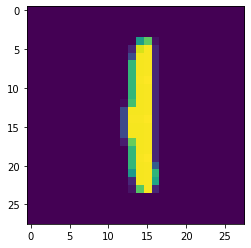

In [5]:
n_samples_train = 12000
i = np.random.randint(0, n_samples_train)
img = Image.fromarray(x_train[i])
plt.imshow(img)

y_train[i]

In [14]:
images, labels = (x_train[0:n_samples_train].reshape(n_samples_train,28*28) /255, y_train[0:n_samples_train].reshape(n_samples_train,1)) 
df = pd.DataFrame(images)
images.shape,labels.shape

((12000, 784), (12000, 1))

In [17]:
# params_ , cost_ = train(images,labels,[images.shape[1],6,4,labels.shape[1]],n_iters=2000,alpha =  0.01,lambda_=10,)
nn =NeuralNetwork(images,labels,[images.shape[1],6,4,labels.shape[1]])
nn.train()

iter: 0 cost: 0.4632096344806824 Accuracy: 0.5260833333333333
----------------------------------------------------------------------
iter: 50 cost: 0.46169429140673685 Accuracy: 0.5309166666666667
----------------------------------------------------------------------
iter: 100 cost: 0.46000116922829043 Accuracy: 0.5328333333333334
----------------------------------------------------------------------
iter: 150 cost: 0.4580865437084624 Accuracy: 0.5341666666666667
----------------------------------------------------------------------
iter: 200 cost: 0.45564195061163193 Accuracy: 0.53625
----------------------------------------------------------------------
iter: 250 cost: 0.45274052601097564 Accuracy: 0.5384166666666667
----------------------------------------------------------------------
iter: 300 cost: 0.44985131146690494 Accuracy: 0.5401666666666667
----------------------------------------------------------------------
iter: 350 cost: 0.4467346117816023 Accuracy: 0.5421666666666667


({'W1': array([[-0.15935924, -0.77568353, -2.26452894,  0.92887557,  0.53613994,
           0.15236567],
         [-0.39521572, -1.01889899, -0.99574378, -2.49636223,  0.08807926,
           0.63569728],
         [ 0.71856942,  0.40195058, -0.46827491, -2.13394468,  1.46691144,
           1.60273378],
         ...,
         [ 1.46154812,  0.89920765,  0.44621529, -0.38259997,  0.37582843,
          -0.43720401],
         [-1.15167094,  1.3138201 ,  2.36833755, -1.05542575,  2.08955855,
          -0.52927794],
         [-0.09496824,  0.4686753 ,  1.65290644,  1.10940309,  0.04526008,
          -0.14742627]]),
  'b1': array([[ 0.02741696, -0.01091918,  0.01545579, -0.00537061, -0.01557522,
          -0.00425877]]),
  'W2': array([[ 0.53649679,  1.77965155, -0.5405515 , -0.54497726],
         [ 0.30019243,  0.10624271, -0.97405411,  0.01051687],
         [-0.62092189, -0.30809234,  0.24574907,  0.46908385],
         [ 0.76061344,  0.54109117,  0.63902043,  0.78695161],
         [-0.928169

In [35]:
plt.plot(np.arange(len(cost_)),cost_)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

NameError: name 'cost_' is not defined

Testing the Trained Neural Network

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score ,f1_score
def evaluate(input_X,output_y,parameters,threshold=0.5):
    predictions = predict(input_X, parameters,threshold)
    print( " precision:" , str(precision_score(output_y,predictions))[:5],"\n",
    "recall:",str(recall_score(output_y,predictions))[:5],"\n",
    "fl score:",str(f1_score(output_y,predictions))[:5],"\n",
    "accuracy:",str((predictions == output_y).all(axis=1).mean())[:5])
    results = confusion_matrix(output_y,predictions)
    fig, ax = plt.subplots()
    ax.matshow(results)
    for (i, j), z in np.ndenumerate(results):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.show()

In [18]:
n_test_samples = x_test.shape[0]
testX = x_test.reshape(n_test_samples,28*28)/255
testY = y_test.reshape(n_test_samples,1)
nn.evaluate(testX,testY)

TypeError: predict() takes 3 positional arguments but 4 were given

Threshold: 0.5
-------------test set-------------
 precision: 0.971 
 recall: 0.968 
 fl score: 0.969 
 accuracy: 0.967


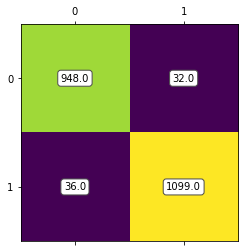

-------------train set-------------
 precision: 0.977 
 recall: 0.960 
 fl score: 0.968 
 accuracy: 0.967


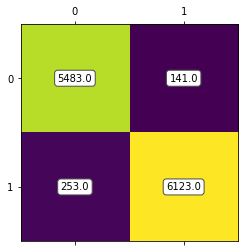

In [18]:
thres = 0.5
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)


Threshold: 0.8
-------------test set-------------
 precision: 0.976 
 recall: 0.958 
 fl score: 0.967 
 accuracy: 0.965


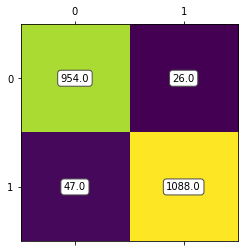

-------------train set-------------
 precision: 0.981 
 recall: 0.949 
 fl score: 0.964 
 accuracy: 0.963


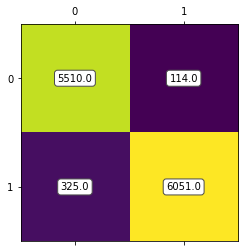

In [19]:
thres = 0.8
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)

Threshold: 0.3
-------------test set-------------
 precision: 0.967 
 recall: 0.973 
 fl score: 0.970 
 accuracy: 0.968


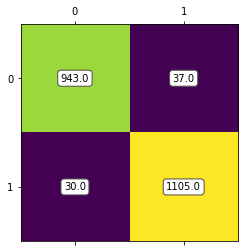

-------------train set-------------
 precision: 0.974 
 recall: 0.964 
 fl score: 0.969 
 accuracy: 0.968


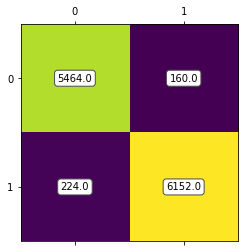

In [20]:
thres = 0.3
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)

Threshold: 0.7
-------------test set-------------
 precision: 0.975 
 recall: 0.962 
 fl score: 0.968 
 accuracy: 0.966


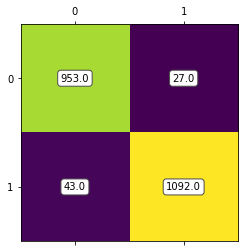

-------------train set-------------
 precision: 0.980 
 recall: 0.954 
 fl score: 0.967 
 accuracy: 0.965


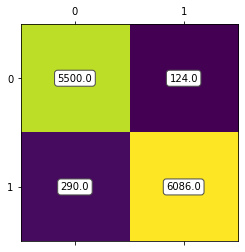

In [21]:
thres = 0.7
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)

Threshold: 0.9
-------------test set-------------
 precision: 0.978 
 recall: 0.950 
 fl score: 0.964 
 accuracy: 0.962


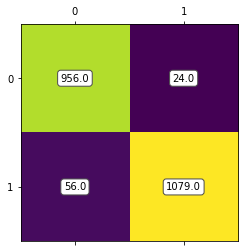

-------------train set-------------
 precision: 0.982 
 recall: 0.940 
 fl score: 0.960 
 accuracy: 0.959


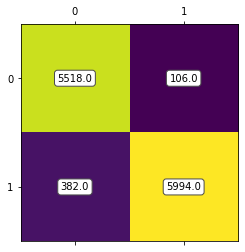

In [23]:
thres = 0.9
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)